<a href="https://colab.research.google.com/github/Shakibap/Data-Science-Portfo/blob/Data-Science/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the Response**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

In [99]:
from google.colab import files
#files.upload()

In [4]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [96]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Couple,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Couple,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Couple,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# **Data Cleaning**

In [98]:
df.shape

(2232, 29)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2232 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2232 non-null   int64         
 1   Year_Birth           2232 non-null   int64         
 2   Education            2232 non-null   object        
 3   Marital_Status       2232 non-null   object        
 4   Income               2208 non-null   float64       
 5   Kidhome              2232 non-null   int64         
 6   Teenhome             2232 non-null   int64         
 7   Dt_Customer          2232 non-null   datetime64[ns]
 8   Recency              2232 non-null   int64         
 9   MntWines             2232 non-null   int64         
 10  MntFruits            2232 non-null   int64         
 11  MntMeatProducts      2232 non-null   int64         
 12  MntFishProducts      2232 non-null   int64         
 13  MntSweetProducts     2232 non-nul

In [7]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer)

**finding the outliers**

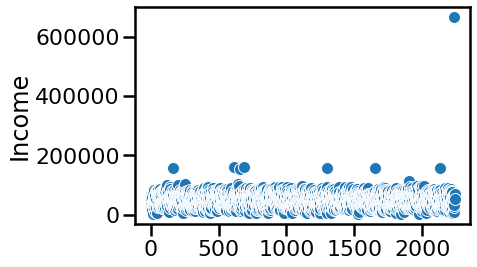

In [8]:
sns.set_context("poster")
sns.scatterplot(x=df.index, y= df.Income)

In [9]:
df.Income.idxmax()

2233

In [10]:
#removing the outlier data point
df.drop(index=2233, inplace=True)

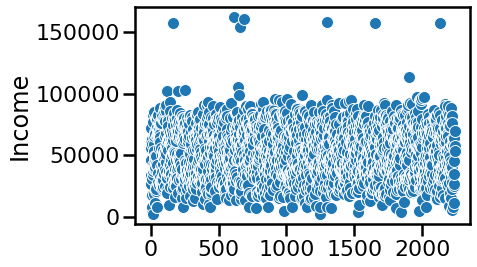

In [11]:
sns.scatterplot(x=df.index, y= df.Income)

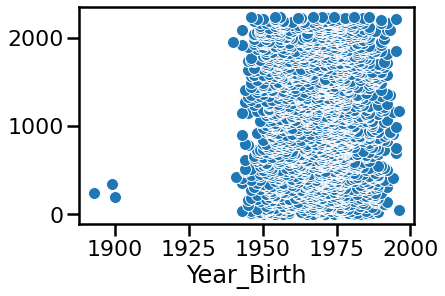

In [12]:
sns.scatterplot(x=df.Year_Birth, y=df.index)

In [13]:
df[df["Year_Birth"] < 1915]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,3,11,0
239,11004,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,3,11,0
339,1150,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,3,11,0


In [14]:

#removing the outlier data point
df.drop(index=[192, 239, 339] , inplace=True)

**concatenating the similar features**

In [15]:
df.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

*Divorced, Widow and Alone are considered as Single*

*Together and Married are considered as Couple* 

In [16]:
#changing Divorced, Widow and Alone data points to Single. Also considering Together and Married data points as Couple.
df.Marital_Status.replace('Divorced' , 'Single', inplace=True)
df.Marital_Status.replace('Widow' , 'Single', inplace=True)
df.Marital_Status.replace('Alone' , 'Single', inplace=True)
df.Marital_Status.replace('Married' , 'Couple', inplace=True)
df.Marital_Status.replace('Together' , 'Couple', inplace=True)

In [17]:
df.Marital_Status.unique()

array(['Single', 'Couple', 'Absurd', 'YOLO'], dtype=object)

In [18]:
df[df.Marital_Status.isin(['Absurd', 'YOLO'])]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2093,7734,1993,Graduation,Absurd,79244.0,0,0,2012-12-19,58,471,102,125,212,61,245,1,4,10,7,1,0,0,1,1,0,0,3,11,1
2134,4369,1957,Master,Absurd,65487.0,0,0,2014-10-01,48,240,67,500,199,0,163,3,3,5,6,2,0,0,0,0,0,0,3,11,0
2177,492,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,50,4,3,42,5,7,1,6,8,0,0,0,0,0,0,3,11,0
2202,11133,1973,PhD,YOLO,48432.0,0,1,2012-10-18,3,322,3,50,4,3,42,5,7,1,6,8,0,0,0,0,0,0,3,11,1


In [19]:
#removing outliers
df.drop(index=[2093, 2134, 2177, 2202] , inplace=True)

# **Data Preprocessing**

In [20]:
X_full = df.loc[ : , 'Year_Birth': 'Z_Revenue']
y_full = df.Response

In [21]:
X_full['Dt_Customer'] = X_full.Dt_Customer.astype('int64')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=1)

In [23]:
#X_train.isnull().sum()
#X_test.isnull().sum()

In [24]:
#imputing missing values
imputer = SimpleImputer()

x_train_income = imputer.fit_transform(X_train[['Income']])
x_test_income = imputer.transform(X_test[['Income']])

X_train.Income = x_train_income
X_test.Income = x_test_income

In [25]:
#encoding categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [26]:
#finding the percent of 1 in label
y_full.sum()/y_full.shape[0]

0.14874551971326164

*the labels are in two categories, 0 and 1. because the number of 1 is in minority (about 15%), the **f1_score** of label 1 is the **evaluation metric**.*

# **Modelling**

# *choosing potential classifiers*

Random Forest Classifier


In [27]:
#fitting data to the model
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       470
           1       0.74      0.35      0.48        88

    accuracy                           0.88       558
   macro avg       0.81      0.66      0.70       558
weighted avg       0.87      0.88      0.86       558



AdaBoost Classifier

In [28]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       470
           1       0.67      0.45      0.54        88

    accuracy                           0.88       558
   macro avg       0.79      0.71      0.74       558
weighted avg       0.87      0.88      0.87       558



Gradient Boosting Classifier

In [29]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       470
           1       0.70      0.42      0.52        88

    accuracy                           0.88       558
   macro avg       0.80      0.69      0.73       558
weighted avg       0.87      0.88      0.87       558



XGB Classifier

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       470
           1       0.70      0.43      0.54        88

    accuracy                           0.88       558
   macro avg       0.80      0.70      0.73       558
weighted avg       0.87      0.88      0.87       558



KNeighbors Classifier

In [31]:
scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.loc[:] = scaler.fit_transform(X_train)
X_test_scaled.loc[:] = scaler.transform(X_test)

In [32]:
model = KNeighborsClassifier()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       470
           1       0.52      0.25      0.34        88

    accuracy                           0.85       558
   macro avg       0.70      0.60      0.63       558
weighted avg       0.82      0.85      0.82       558



Support Vector Classifier

In [33]:
model = SVC()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       470
           1       0.73      0.27      0.40        88

    accuracy                           0.87       558
   macro avg       0.80      0.63      0.66       558
weighted avg       0.85      0.87      0.84       558



*classifiers with f1_score more than 0.5 are selected as potential classifiers*

# Feature Engineering

**creating new feature**

In [34]:
X_train_new = X_train.copy()
X_test_new = X_test.copy()

In [35]:
# creating a new feature by summation of 6 features
X_train_new['Total_Spent'] = X_train_new.loc[: ,"MntWines":"MntGoldProds"].sum(axis=1)
X_test_new['Total_Spent'] = X_test_new.loc[: ,"MntWines":"MntGoldProds"].sum(axis=1)

X_train_new.drop(X_train_new.loc[:, "MntWines":"MntGoldProds"], axis=1, inplace=True)
X_test_new.drop(X_test_new.loc[:, "MntWines":"MntGoldProds"], axis=1, inplace=True)

AdaBoost Classifier

In [36]:
# fitting the new data to the model
model = AdaBoostClassifier()
model.fit(X_train_new, y_train)
predictions = model.predict(X_test_new)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       470
           1       0.68      0.45      0.54        88

    accuracy                           0.88       558
   macro avg       0.79      0.71      0.74       558
weighted avg       0.87      0.88      0.87       558



Gradient Boosting Classifier

In [37]:
model = GradientBoostingClassifier()
model.fit(X_train_new, y_train)
predictions = model.predict(X_test_new)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       470
           1       0.74      0.42      0.54        88

    accuracy                           0.89       558
   macro avg       0.82      0.70      0.74       558
weighted avg       0.87      0.89      0.87       558



XGB Classifier

In [38]:
model = XGBClassifier()
model.fit(X_train_new, y_train)
predictions = model.predict(X_test_new)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       470
           1       0.71      0.41      0.52        88

    accuracy                           0.88       558
   macro avg       0.80      0.69      0.72       558
weighted avg       0.87      0.88      0.87       558



*GB Classifier is improved, so adding the new feature could be effective*

**feature selection**

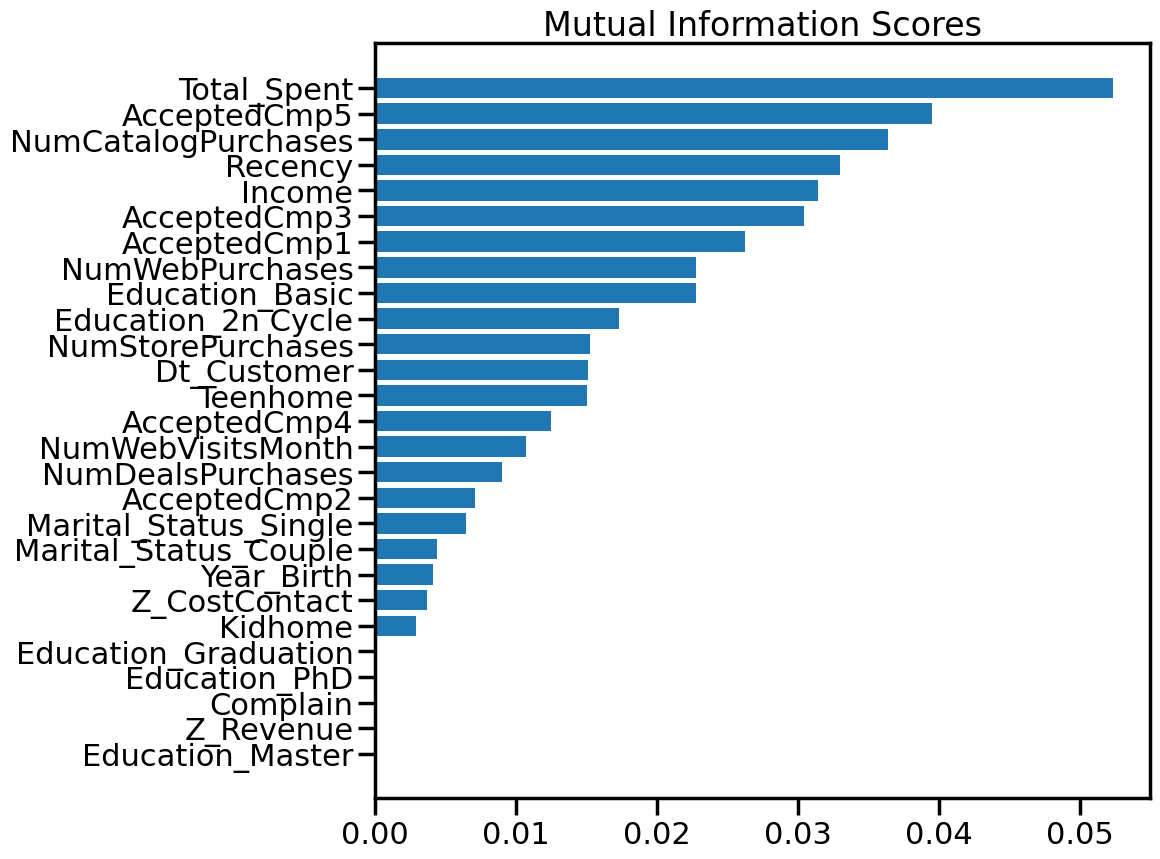

In [55]:
# calculating mutual information scores to find the most effective features 
def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, random_state=1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train_new, y_train)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores)

In [40]:
# selecting the features with mi_score more than zero 
features = mi_scores[mi_scores>0].index

In [41]:
X_train_selected = X_train_new[features].copy()
X_test_selected = X_test_new[features].copy()

AdaBoost Classifier

In [42]:
# fitting the selected features to the model
model = AdaBoostClassifier()
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       470
           1       0.67      0.48      0.56        88

    accuracy                           0.88       558
   macro avg       0.79      0.72      0.74       558
weighted avg       0.87      0.88      0.87       558



Gradient Boosting Classifier

In [43]:
model = GradientBoostingClassifier()
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       470
           1       0.76      0.43      0.55        88

    accuracy                           0.89       558
   macro avg       0.83      0.70      0.74       558
weighted avg       0.88      0.89      0.88       558



XGB Classifier

In [44]:
model = XGBClassifier()
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       470
           1       0.77      0.39      0.52        88

    accuracy                           0.89       558
   macro avg       0.83      0.68      0.73       558
weighted avg       0.88      0.89      0.87       558



GB and AdaBoost Classifiers are improved, so feature selection could be effective

**PCA**

In [45]:
#scaling the data
scaler = MinMaxScaler()

X_train_selected_scaled = X_train_selected.copy()
X_test_selected_scaled = X_test_selected.copy()

X_train_selected_scaled.loc[:] = scaler.fit_transform(X_train_selected)
X_test_selected_scaled.loc[:] = scaler.transform(X_test_selected)

In [46]:
#fitting the scaled data to PCA
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(X_train_selected_scaled)
x_test_pca = pca.transform(X_test_selected_scaled)

In [47]:
pca.explained_variance_ratio_

array([0.33989014, 0.14827436, 0.07585536, 0.06431959, 0.05890411])

*These ratios do not seem promising*

# Hyperparameter Tuning

AdaBoost Classifier

In [48]:
#optimizing the classifier by tuning the learning_rate
model = AdaBoostClassifier(learning_rate=0.985)
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       470
           1       0.73      0.51      0.60        88

    accuracy                           0.89       558
   macro avg       0.82      0.74      0.77       558
weighted avg       0.88      0.89      0.88       558



Gradient Boosting Classifier

In [49]:
model = GradientBoostingClassifier(learning_rate=0.45)
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)

print(model.score(X_train_selected, y_train), model.score(X_test_selected, y_test))
print(classification_report(y_test, predictions))

0.9898446833930705 0.9086021505376344
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       470
           1       0.78      0.58      0.67        88

    accuracy                           0.91       558
   macro avg       0.85      0.77      0.81       558
weighted avg       0.90      0.91      0.90       558



XGB Classifier

In [50]:
model = XGBClassifier(learning_rate=0.945)

model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)

print(model.score(X_train_selected, y_train), model.score(X_test_selected, y_test))
print(classification_report(y_test, predictions))

0.992831541218638 0.899641577060932
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       470
           1       0.72      0.59      0.65        88

    accuracy                           0.90       558
   macro avg       0.82      0.77      0.80       558
weighted avg       0.89      0.90      0.90       558



both of the Gradient Boost and XGBoost could be the best classifiers so far

#tunning more hyperparameters


Gradient Boosting classifier

In [51]:
#tuning other hyperparameters to optimize the model as much as possible
model = GradientBoostingClassifier(learning_rate=0.45,max_depth=3,
                                   min_samples_split=6, n_estimators=100)
model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)

print(classification_report(y_test, predictions))
print('The accuracy of train data: {}'.format(model.score(X_train_selected, y_train)))
print('The accuracy of test data: {}'.format(model.score(X_test_selected, y_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       470
           1       0.77      0.60      0.68        88

    accuracy                           0.91       558
   macro avg       0.85      0.78      0.81       558
weighted avg       0.90      0.91      0.90       558

The accuracy of train data: 0.9904420549581839
The accuracy of test data: 0.9086021505376344


XGB Classifier

In [52]:
model = XGBClassifier(learning_rate=0.945, n_estimators=105)

model.fit(X_train_selected, y_train)
predictions = model.predict(X_test_selected)

print(classification_report(y_test, predictions))
print('The accuracy of train data: {}'.format(model.score(X_train_selected, y_train)))
print('The accuracy of test data: {}'.format(model.score(X_test_selected, y_test)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       470
           1       0.74      0.60      0.66        88

    accuracy                           0.90       558
   macro avg       0.83      0.78      0.80       558
weighted avg       0.90      0.90      0.90       558

The accuracy of train data: 0.992831541218638
The accuracy of test data: 0.9032258064516129


GB Classifier has the highest f1_score (0.68 for label 1 and 0.95 for label 0)

# **Final Model**

In [53]:
X = pd.concat([X_train_selected, X_test_selected])
y = pd.concat([y_train, y_test])

In [54]:
final_model = GradientBoostingClassifier(learning_rate=0.45,max_depth=3,
                                   min_samples_split=6, n_estimators=100)
final_model.fit(X, y)

GradientBoostingClassifier(learning_rate=0.45, min_samples_split=6)